In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [2]:
train_df = pd.read_csv("sample_prccd_train.csv")
test_df = pd.read_csv("sample_prccd_test.csv")
train_df.columns

Index(['item_id', 'item', 'label'], dtype='object')

b'Other Useful Information' 	 0.2780373831775701
b'Infrastructure and utilities' 	 0.09579439252336448
b'Affected individuals' 	 0.10455607476635514
b'Not related or irrelevant' 	 0.29439252336448596
b'Donations and volunteering' 	 0.1594626168224299
b'Sympathy and support' 	 0.06775700934579439


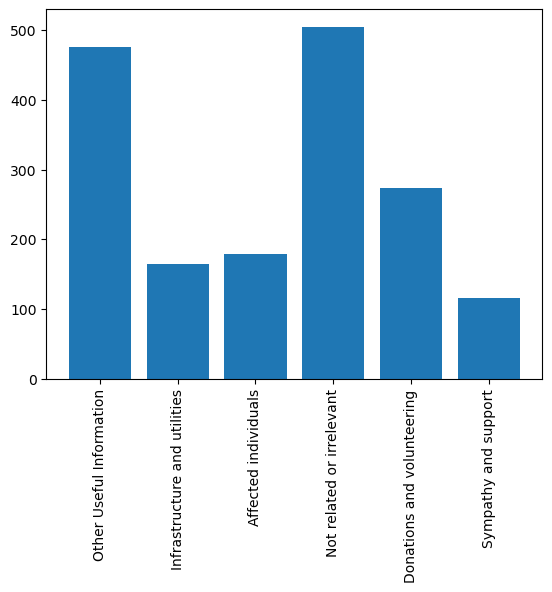

In [3]:
train_text = train_df["item"]
train_labels = train_df["label"]

test_text = test_df["item"]
test_labels = test_df["label"]

train_text = train_text.str.lower()
train_text = train_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda x : nltk.word_tokenize(x))
train_text = train_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["httpaddress", "rt", "userid", "usrid", "http"])]))

test_text = test_text.str.lower()
test_text = test_text.apply(lambda elem: re.sub(r"\d+", "", elem))
test_text = test_text.apply(lambda x : nltk.word_tokenize(x))
test_text = test_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["httpaddress", "rt", "userid", "usrid", "http"])]))

train_text = tf.convert_to_tensor(train_text)
train_labels = tf.convert_to_tensor(train_labels)

test_text = tf.convert_to_tensor(test_text)
test_labels = tf.convert_to_tensor(test_labels)

labels = tf.unique(train_labels)[0]
#print(np.array(tf.unique(train_labels)[1]))

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [4]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [5]:
preprocessed_text = bert_preprocess_model(train_text)

preprocessed_test_text = bert_preprocess_model(test_text)
preprocessed_text.keys()

dict_keys(['input_word_ids', 'input_type_ids', 'input_mask'])

In [6]:
bert_model = hub.KerasLayer(encoder_url)

In [7]:
bert_results = bert_model(preprocessed_text)

bert_test_results = bert_model(preprocessed_test_text)
bert_results.keys()

dict_keys(['sequence_output', 'default', 'encoder_outputs', 'pooled_output'])

In [8]:
print("default", bert_results["default"].shape)
print("pooled_output", bert_results["pooled_output"].shape)
print("sequence_output", bert_results["sequence_output"].shape)
# these are the outputs of the 12 encoder layers: bert_results["encoder_outputs"]

default (1712, 768)
pooled_output (1712, 768)
sequence_output (1712, 128, 768)


In [9]:
#print("sequence_output", bert_results["sequence_output"].shape)
#print(type(bert_results["sequence_output"]))
sequence_output = np.array(bert_results["sequence_output"])
#print("Before:", sequence_output)
flat_sequence_output = sequence_output.reshape(1712, 128*768)
#print("After:", flat_sequence_output)

test_X = np.array(bert_test_results["sequence_output"]).reshape(484, 128*768)

In [10]:
from sklearn import neural_network

# clf = neural_network.MLPClassifier(hidden_layer_sizes=(32,), max_iter = 100)
# clf.fit(flat_sequence_output, tf.unique(train_labels)[1])


In [11]:
# print("Train accuracy:", np.mean(clf.predict(flat_sequence_output) == tf.unique(train_labels)[1]))
# print("Test accuracy:", np.mean(clf.predict(test_X) == tf.unique(test_labels)[1]))

In [16]:
clf1 = neural_network.MLPClassifier(hidden_layer_sizes=(100,100))
clf1.fit(bert_results["pooled_output"], tf.unique(train_labels)[1])

MLPClassifier(hidden_layer_sizes=(100, 100))

In [17]:
print("Train accuracy:", np.mean(clf1.predict(bert_results["pooled_output"]) == tf.unique(train_labels)[1]))
print("Test accuracy:", np.mean(clf1.predict(bert_test_results["pooled_output"]) == tf.unique(test_labels)[1]))

Train accuracy: 0.717873831775701
Test accuracy: 0.3615702479338843


b'Other Useful Information' 	 0.2780373831775701
b'Infrastructure and utilities' 	 0.09579439252336448
b'Affected individuals' 	 0.10455607476635514
b'Not related or irrelevant' 	 0.29439252336448596
b'Donations and volunteering' 	 0.1594626168224299
b'Sympathy and support' 	 0.06775700934579439


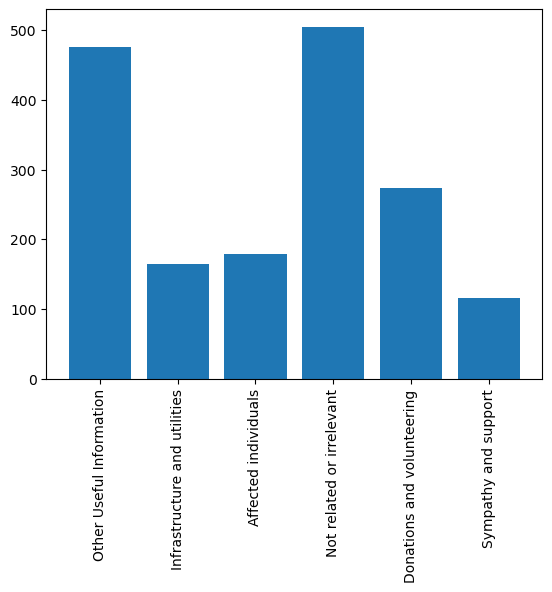

b'Other Useful Information' 	 0.27892561983471076
b'Infrastructure and utilities' 	 0.09504132231404959
b'Affected individuals' 	 0.29545454545454547
b'Not related or irrelevant' 	 0.06611570247933884
b'Donations and volunteering' 	 0.1590909090909091
b'Sympathy and support' 	 0.10537190082644628


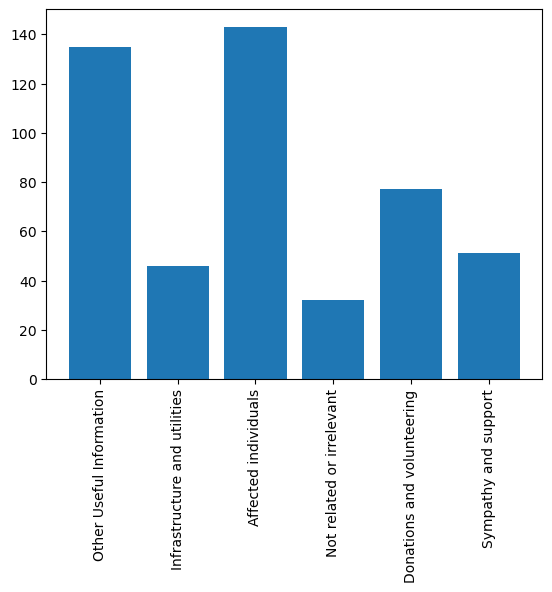

In [19]:
for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(test_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(test_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
model = tf.keras.squential(
  Input(pooled_output)
  Dense(100, 100)
  Dense(6)
)